In [1]:
import botorch
from known_boundary.acquisition_function import EI_acquisition_opt,SLogTEI_acquisition_opt,SLogEI_acquisition_opt
from known_boundary.utlis import  get_initial_points,transform,opt_model_MLE,opt_model_MAP
import numpy as np
import GPy
import torch
from botorch.test_functions import Ackley,Levy,Beale,Branin,Hartmann,Rosenbrock,Powell,SixHumpCamel
from botorch.utils.transforms import unnormalize,normalize
from known_boundary.SLogGP import SLogGP
import scipy 

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('lengthscale').disabled = True
logging.getLogger('variance').disabled = True
logging.getLogger('psi').disabled = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double



/home/hanyang/anaconda3/envs/known_boundary/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
lengthscale_range = [0.001,2]
variance_range = [0.001**2,4**2]
noise = 1e-6

In [6]:
fun =  Ackley(dim=2,negate=False)

dim = fun.dim
bounds = fun.bounds
standard_bounds=np.array([0.,1.]*dim).reshape(-1,2)

if dim <=3:
    step_size = 2
elif dim<=7:
    step_size = 3
else:
    step_size = 4
    
n_init = 4*dim
iter_num = 50
N = 20

fstar = 0.


# EI

In [7]:
BO_EI = []
noise = 1e-6

for exp in range(N):
    
    print(exp)
    
    seed = exp

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)

    best_record = [Y_BO.min().item()]
    np.random.seed(1234)

    for i in range(iter_num):

            print(i)
        
            train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std()
            train_X = normalize(X_BO, bounds)
            
            minimal = train_Y.min().item()
            
            train_Y = train_Y.numpy()
            train_X = train_X.numpy()
            
            # train the GP
            if i%step_size == 0:
                
                parameters = opt_model_MLE(train_X,train_Y,dim,'GP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range)
                    
                lengthscale = parameters[0]
                variance = parameters[1]
                
                print('lengthscale: ',lengthscale)
                print('variance: ',variance)
                
                
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale,variance=variance)
            m = GPy.models.GPRegression(train_X.reshape(-1,dim), train_Y.reshape(-1,1),kernel)
            m.Gaussian_noise.fix(noise)
            
            standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=minimal)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)
            
            print(standard_next_X)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            
            noise = variance*10**(-5)
            print('noise: ',noise)
            
            print(best_record[-1])
            
    best_record = np.array(best_record) 
    BO_EI.append(best_record)

0
0
lengthscale:  0.1762324387738113
variance:  0.8980480498126637
[0.40384999 0.60585944]
noise:  8.980480498126637e-06
13.359805351914142
1
[0.5376919  0.55680812]
noise:  8.980480498126637e-06
11.52394433871543
2
lengthscale:  0.14878567335128173
variance:  0.697704501531551
[0.53448274 0.49469215]
noise:  6.97704501531551e-06
7.517365285908001
3
[0.50706922 0.42775693]
noise:  6.97704501531551e-06
7.517365285908001
4
lengthscale:  0.07779900192340009
variance:  0.7108283475937056
[0.49947559 0.50011827]
noise:  7.108283475937057e-06
0.13237677035672535
5
[0.46335884 0.50006714]
noise:  7.108283475937057e-06
0.13237677035672535
6
lengthscale:  0.03716545668802192
variance:  0.7232848018345704
[0.49999176 0.51892373]
noise:  7.232848018345705e-06
0.13237677035672535
7
[0.49746862 0.48645704]
noise:  7.232848018345705e-06
0.13237677035672535
8
lengthscale:  0.025933032276358174
variance:  0.6523941680774695
[0.49123844 0.50235814]
noise:  6.523941680774695e-06
0.13237677035672535
9
[0

# SLogEI (no boundary)

In [11]:
SLogEI_noboundary = []

for exp in range(1):

    seed = 0
    
    print(exp)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)



    best_record = [Y_BO.min().item()]
    np.random.seed(1234)

    for i in range(iter_num):

            print('inner loop: ',i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            train_Y_std = np.std(train_Y)
            lower = -np.min(train_Y)+10**(-6)
            upper = lower+2000 #min(300,5*train_Y_std+50)
            
            c_range = [lower,upper]

            if i%step_size == 0:
                
                parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
    
                lengthscale = parameters[0]
                variance = parameters[1]
                c = parameters[2]
                
                print('lengthscale is ',lengthscale)
                print('variance is ',variance)
                print('c is ',c)
                
            if variance>-1: 
                print('SLogGP')
                warp_Y = np.log(train_Y+c)
                mean_warp_Y = np.mean(warp_Y) # use to predict mean
                warp_Y_standard = warp_Y-mean_warp_Y
                
                
                kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
                m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
                m.Gaussian_noise.variance.fix(noise)    
                standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
            
            
            else: # when the variance is too small, to aviod numerical issue, we treat SLogGP as a GP
                print('treat as GP')
                train_Y = (Y_BO - Y_BO.mean()) / Y_BO.std() 
                #minimal = train_Y.min().item()
                train_Y = train_Y.numpy()
                
                if i%step_size == 0:
                    parameters = opt_model_MLE(train_X,train_Y,dim,'GP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range)
                    lengthscale_GP = parameters[0]
                    variance_GP = parameters[1]
                    
                    print('lengthscale GP: ',lengthscale_GP)
                    print('variance GP: ',variance_GP)
                
                kernel = GPy.kern.RBF(input_dim=dim,lengthscale=lengthscale_GP,variance=variance_GP)
                m = GPy.models.GPRegression(train_X.reshape(-1,dim), train_Y.reshape(-1,1),kernel)
                m.Gaussian_noise.fix(noise)
                
                standard_next_X = EI_acquisition_opt(m,bounds=standard_bounds,f_best=np.min(train_Y))
                    
            
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)
            
            print(standard_next_X)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)         
    SLogEI_noboundary.append(best_record)

0
inner loop:  0
lengthscale is  0.17587332174436965
variance is  1.792402497156458e-06
c is  1986.637660751699
SLogGP
[0.40402331 0.60582876]
13.359805351914142
inner loop:  1
SLogGP
[0.53628135 0.55253108]
11.213461903760157
inner loop:  2
lengthscale is  0.14404876053178617
variance is  9.06833715941621e-06
c is  1081.3028106844115
SLogGP
[0.53945228 0.49230846]
8.543759702411089
inner loop:  3
SLogGP
[0.52078519 0.43846908]
8.543759702411089
inner loop:  4
lengthscale is  0.09504483098279047
variance is  4.245514358259926e-06
c is  1991.4562412975865
SLogGP
[0.58779457 0.46896947]
8.543759702411089
inner loop:  5
SLogGP
[0.4981215  0.49634748]
1.986715885896626
inner loop:  6
lengthscale is  0.05808988709006886
variance is  8.003013797412095e-06
c is  1998.0132851141034
SLogGP
[0.47295242 0.49879735]
1.986715885896626
inner loop:  7
SLogGP
[0.49850238 0.51184361]
1.986715885896626
inner loop:  8
lengthscale is  0.04277303014269096
variance is  8.079525533783749e-06
c is  1998.01146

In [62]:
9.675509314704186e-05>5*10**(-5)

True

In [31]:
X_BO

tensor([[ 18.1919,  30.7275],
        [-12.8880, -26.0185],
        [-18.8071,   2.2492],
        [ 15.3929,  -5.4842],
        [  7.1037,  15.1018],
        [-28.3923, -10.0728],
        [ -5.5753,  18.9955],
        [ 24.7207, -22.4225],
        [  6.8097,  15.5099],
        [  7.4551,  14.6141],
        [-11.1513, -27.0096],
        [  7.8928,  15.6270],
        [  6.3929,  14.5462]], dtype=torch.float64)

In [32]:
Y_BO

tensor([[21.4760],
        [19.9830],
        [20.1505],
        [20.3237],
        [18.6075],
        [21.3755],
        [20.4454],
        [21.9534],
        [20.1667],
        [20.3287],
        [20.1949],
        [19.9939],
        [20.1852]], dtype=torch.float64)

# SLogTEI (enforced boundary)

In [115]:
SLogEI_enforceboundary = []

for exp in range(N):

    seed = exp
    
    print(exp)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)



    best_record = [Y_BO.min().item()]
    np.random.seed(1234)

    for i in range(iter_num):

            print('inner loop: ',i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            lower = -fstar+10**(-6)
            upper = lower+0.3
            
            c_range = [lower,upper]

            if i%step_size == 0:
                parameters = opt_model_MLE(train_X,train_Y,dim,'SLogGP',noise=noise,seed=i,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
    
                lengthscale = parameters[0]
                variance = parameters[1]
                c = parameters[2]
            
            
                # print('lengthscale is ',lengthscale)
                # print('variance is ',variance)
                # print('c is ',c)
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(noise)
            
            standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)         
    SLogEI_enforceboundary.append(best_record)

0
inner loop:  0
lengthscale is  0.1914574617014607
variance is  9.999917101542946
c is  0.0048213209405569765
41.541068023078196
inner loop:  1
30.06117217160515
inner loop:  2
lengthscale is  0.1451600842807204
variance is  9.448107024956721
c is  3.128903479162578e-05
30.06117217160515
inner loop:  3
30.06117217160515
inner loop:  4
lengthscale is  0.0480260422963715
variance is  9.999957720470077
c is  8.238386084693021e-05
30.06117217160515
inner loop:  5
1.7364309520793908
inner loop:  6
lengthscale is  0.04178679997138895
variance is  9.999995747920305
c is  0.29993068540703444
1.7364309520793908
inner loop:  7
1.7364309520793908
inner loop:  8
lengthscale is  0.019493161661158595
variance is  9.999998793167384
c is  2.2075997491730104e-06
1.7364309520793908
inner loop:  9
1.7364309520793908
inner loop:  10
lengthscale is  0.010000012706428023
variance is  9.999980423879858
c is  0.299994269263333
1.7364309520793908
inner loop:  11
1.7364309520793908
inner loop:  12
lengthscale 

# SLogEI (boundary and second version)

In [4]:
def range_transform(lower1,upper1,lower2,upper2,ratio): #lower 2 must be larger than lower 1
    
    if upper1>upper2:
        upper_dist = upper1-upper2
        upper_res = upper2+ratio*upper_dist
    else:
        upper_res = upper2
        
    lower_dist = lower2-lower1
    lower_res = lower2 - ratio*lower_dist
    
    return lower_res,upper_res

In [5]:
SLogEI_flexibleboundary = []

for exp in range(N):

    seed = exp
    
    print(exp)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)



    best_record = [Y_BO.min().item()]
    np.random.seed(1234)
    
  
    

    for i in range(iter_num):
        
            trans_ratio = scipy.stats.beta.cdf(x=i/iter_num,a=10,b=1)

            print('inner loop: ',i)
            print('trans_ratio:', trans_ratio)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            train_Y_std = np.std(train_Y)
            lower1 = -np.min(train_Y)+10**(-6)
            upper1 = lower1+min(500,5*train_Y_std)
                        
            lower2 = -fstar+10**(-6)
            upper2 = lower2+0.3
            
            lower,upper = range_transform(lower1,upper1,lower2,upper2,trans_ratio)
            # print('ratio: ',trans_ratio)
            # print([lower1,upper1])
            # print([lower2,upper2])
            print([lower,upper])
            
            c_range = [lower,upper]

            if i%step_size == 0:
                
                parameters = opt_model(train_X,train_Y,dim,'SLogGP',noise=noise,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
    
                lengthscale = parameters[0]
                variance = parameters[1]
                c = parameters[2]
                
                print('lengthscale is ',lengthscale)
                print('variance is ',variance)
                print('c is ',c)
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(1e-5)
            
            standard_next_X =  SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)         
    SLogEI_flexibleboundary.append(best_record)

0
inner loop:  0
trans_ratio: 0.0


NameError: name 'lower' is not defined

In [8]:
SLogTEI_enforceboundary = []

for exp in range(1):

    seed = exp
    
    print(exp)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1) - fstar



    best_record = [Y_BO.min().item()]
    np.random.seed(1234)

    for i in range(iter_num):

            #print('inner loop: ',i)
        
            train_Y = Y_BO.numpy()
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
            
            lower = -0+10**(-6)
            upper = lower+0.3
            
            c_range = [lower,upper]

            if i%1 == 0:
                
                parameters = opt_model(train_X,train_Y,dim,'SLogGP',noise=noise,lengthscale_range=lengthscale_range,variance_range=variance_range,c_range=c_range)                
    
                lengthscale = parameters[0]
                variance = parameters[1]
                c = parameters[2]
                
                print('lengthscale is ',lengthscale)
                print('variance is ',variance)
                print('c is ',c)
            
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(noise)
            
            standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
            #standard_next_X = SLogTEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y,fstar=fstar)
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1) - fstar

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            best_record.append(Y_BO.min().item())
            print(best_record[-1])
            
    best_record = np.array(best_record)         
    SLogTEI_enforceboundary.append(best_record)

0
lengthscale is  0.2631522365080899
variance is  1.2018619432065911
c is  0.3000008349509791
3.1473098551073155
lengthscale is  0.2400710128796316
variance is  0.5470938465322858
c is  0.30000099999987134
3.1473098551073155
lengthscale is  0.16915346283832786
variance is  0.8272410782194547
c is  0.300000781683504
2.3141435213836274
lengthscale is  0.15917795856977454
variance is  1.1427371757998441
c is  0.3000007279035024
1.9657762845972568
lengthscale is  0.10935217002983122
variance is  1.299244365315773
c is  0.3000007146462817
0.6758279091222804
lengthscale is  0.15677705323314592
variance is  1.7124436671996095
c is  0.30000090052789924
0.6758279091222804
lengthscale is  0.177290932590589
variance is  1.8140276154682171
c is  0.3000009404840323
0.6758279091222804
lengthscale is  0.1723423744085609
variance is  2.137875580261247
c is  0.30000094614550077
0.6758279091222804
lengthscale is  0.16034080896685646
variance is  1.9982164758171843
c is  0.30000094042370784
0.67582790912

In [11]:
LogTEI_boundary = []

for exp in range(N):

    seed = exp
    
    print(exp)

    X_BO = get_initial_points(bounds, n_init,device,dtype,seed=seed)
    Y_BO = torch.tensor(
        [fun(x) for x in X_BO], dtype=dtype, device=device
    ).reshape(-1,1)



    best_record = [Y_BO.min().item()]
    print(best_record[-1])
    np.random.seed(1234)

    for i in range(iter_num):

            print('inner loop: ',i)
        
            train_Y = Y_BO.numpy()
            fstar_shifted = fstar - np.min(train_Y)  # shifted lower bound
            train_Y = train_Y - np.min(train_Y)  # shift Y
            train_X = normalize(X_BO, bounds)
            train_X = train_X.numpy()
    
            mu_prior = np.log(-fstar_shifted+0.3)
            sigma_prior = np.sqrt(np.log(-fstar_shifted+0.3)-np.log(-fstar_shifted))
            prior_parameter = [mu_prior,sigma_prior]
            
            # sigma = 0.3
            # prior_parameter = [np.log(-fstar_shifted)+sigma**2,sigma]
            
            if i%step_size == 0:
                
                best_parameter = opt_model_MAP(train_X,train_Y,dim,lengthscale_range,variance_range,prior_parameter,noise=noise,seed=i)
                
                lengthscale = best_parameter[0]
                variance = best_parameter[1]
                c = best_parameter[2]
                
                print('lengthscale: ',lengthscale)
                print('variance: ',variance)
                print('c: ',c)
            
            
            warp_Y = np.log(train_Y+c)
            mean_warp_Y = np.mean(warp_Y) # use to predict mean
            warp_Y_standard = warp_Y-mean_warp_Y
            
            
            kernel = GPy.kern.RBF(input_dim=dim,lengthscale= lengthscale,variance=variance)  
            m = GPy.models.GPRegression(train_X, warp_Y_standard,kernel)
            m.Gaussian_noise.variance.fix(noise)
            
            if -c>fstar_shifted:
                #print('logEI')
                standard_next_X = SLogEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y)
            else:
                #print('logTEI')
                standard_next_X = SLogTEI_acquisition_opt(model=m,bounds=standard_bounds,f_best=np.min(train_Y),c=c,f_mean=mean_warp_Y,fstar=fstar_shifted)
            
            X_next = unnormalize(torch.tensor(standard_next_X), bounds).reshape(-1,dim)            
            Y_next = fun(X_next).reshape(-1,1)
            
            
            

            # Append data
            X_BO = torch.cat((X_BO, X_next), dim=0)
            Y_BO = torch.cat((Y_BO, Y_next), dim=0)
            
            noise = variance*10**(-5)
            print('noise: ',noise)
            
            best_record.append(Y_BO.min().item())
            print('best so far: ',best_record[-1])
            
    best_record = np.array(best_record)     
    LogTEI_boundary.append(best_record)

0
13.359805351914142
inner loop:  0
lengthscale:  0.1668785116229037
variance:  0.023746076374144883
c:  13.652114050698971
noise:  2.3746076374144886e-07
best so far:  13.359805351914142
inner loop:  1
noise:  2.3746076374144886e-07
best so far:  12.535939782577223
inner loop:  2
lengthscale:  0.12201876386804499
variance:  0.028992850310717726
c:  12.822895927447364
noise:  2.899285031071773e-07
best so far:  12.535939782577223
inner loop:  3
noise:  2.899285031071773e-07
best so far:  3.921422045420258
inner loop:  4
lengthscale:  0.09209644187309923
variance:  5.307858755810523e-05
c:  589.3353410026052
noise:  5.307858755810524e-10
best so far:  3.921422045420258
inner loop:  5
noise:  5.307858755810524e-10
best so far:  3.921422045420258
inner loop:  6
lengthscale:  0.05205183972339433
variance:  7.236316854704178e-06
c:  1781.6367177163493
noise:  7.236316854704179e-11
best so far:  3.921422045420258
inner loop:  7
noise:  7.236316854704179e-11
best so far:  3.123040481533075
in

# Plot

In [9]:
import matplotlib.pyplot as plt

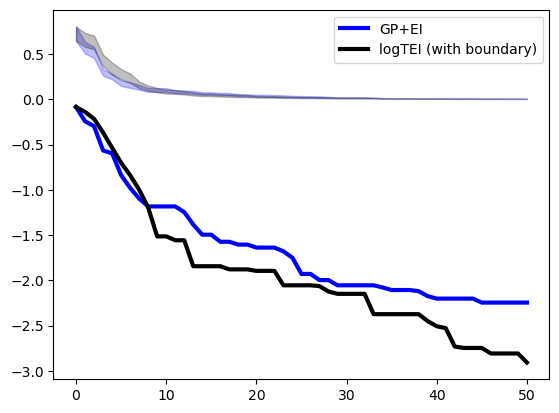

In [16]:
total_record = (np.array(BO_EI)-fstar)  #Hartmann
mean = (np.mean(total_record,axis=0))
bot, mid, top = np.percentile(total_record, [25, 50, 75], axis=0)
mid = np.log10(mid)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mid,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = (np.array(LogTEI_boundary)-fstar)
mean =  (np.mean(total_record,axis=0))
bot, mid, top = np.percentile(total_record, [25, 50, 75], axis=0)
mid = np.log10(mid)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mid,linewidth=3,label='logTEI (with boundary)',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

plt.legend()

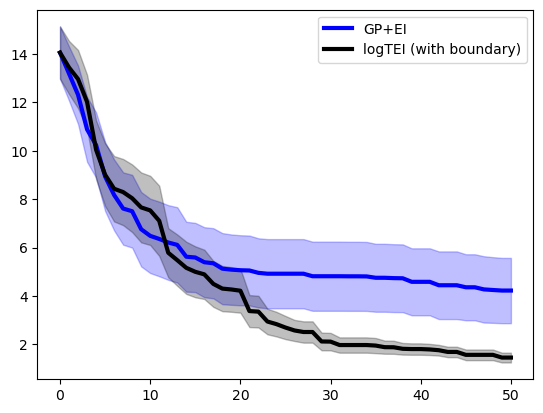

In [13]:
fstar = 0.

total_record = (np.array(BO_EI)-fstar)
mean = (np.mean(total_record,axis=0))
bot, mid, top = np.percentile(total_record, [25, 50, 75], axis=0)
mid = np.log10(mid)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='GP+EI',color='blue')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='blue')

total_record = (np.array(LogTEI_boundary)-fstar)
mean =  (np.mean(total_record,axis=0))
bot, mid, top = np.percentile(total_record, [25, 50, 75], axis=0)
mid = np.log10(mid)
std = np.std(total_record,axis=0)
iter = np.array(range(mean.shape[0]))
plt.plot(mean,linewidth=3,label='logTEI (with boundary)',color='black')
plt.fill_between(iter, mean-std/np.sqrt(N), mean+std/np.sqrt(N),alpha=0.25,color='black')

plt.legend()